In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm_notebook
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"/System/Library/Fonts/STHeiti Light.ttc")

## 匯入資料

In [64]:
df_movie = pd.read_csv("./ml-20m/movies.csv")
df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# 電影數量
len(df_movie)

27278

In [4]:
# 無空值
df_movie.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

In [65]:
# 切出電影年份
import re
year = []
regex = re.compile('\d{4}')
for i in df_movie['title']:
    try:
        year.append(re.findall(regex,i)[-1])
    except:
        year.append(None)
df_movie = pd.concat([df_movie, pd.DataFrame(year, columns=['year'])], axis=1)
df_movie.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


## Exploratory data analysis

In [4]:
types = []
for i in df_movie['genres']:
    for k in i.split('|'):
        types.append(k)
print("總類別數共有：",len(types))

總類別數共有： 54406


### 前10多的電影類別

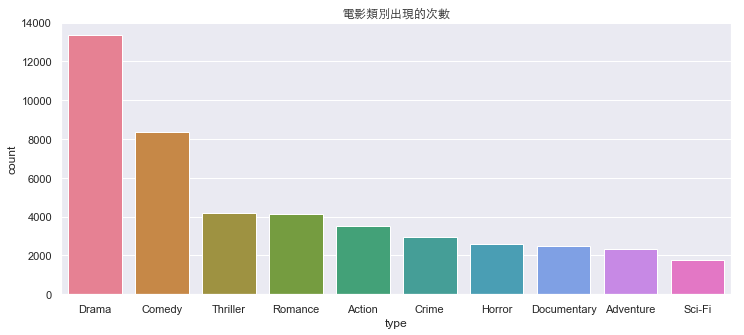

In [48]:
from collections import Counter
df_types = pd.DataFrame(Counter(types).most_common()[:10], columns=['type','count'])
sns.barplot(x='type', y='count', data=df_types, palette='husl')
plt.gcf().set_size_inches(12,5)
plt.title('電影類別出現的次數', fontproperties=font,size=12)
plt.show()

### 看看上述觀眾的喜好如何

In [5]:
df_rating = pd.read_csv("./ml-20m/ratings.csv")

In [66]:
# 整合觀眾對於電影的平均分數
df_temp = pd.DataFrame(df_rating.groupby('movieId')['rating'].mean().reset_index())
df_movie = pd.merge(df_movie, df_temp, on=['movieId'])
df_movie.head()

,movieId,title,genres,year,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,3.921240
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3.211977
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,3.151040
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,2.861393
4,5,Father of the Bride Part II (1995),Comedy,1995,3.064592


In [11]:
types_score = []
for i,j in list(zip(df_movie['genres'],df_movie['rating'])):
    for k in i.split('|'):
        types_score.append([k,j])

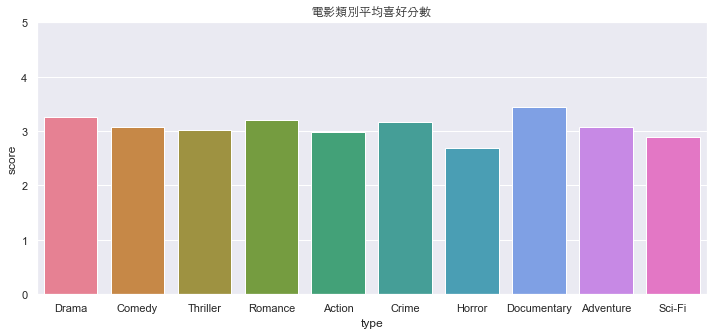

In [22]:
df_types_score = pd.DataFrame(types_score, columns=['type', 'score'])
df_temp = pd.DataFrame(df_types_score.groupby('type')['score'].mean().reset_index())
df_types = pd.merge(df_types, df_temp, on=['type'])
sns.barplot(x='type', y='score', data=df_types, palette='husl')
plt.gcf().set_size_inches(12,5)
plt.title('電影類別平均喜好分數', fontproperties=font,size=12)
plt.ylim(0,5)
plt.show()

### 再看看觀眾看的次數

In [50]:
df_temp = pd.DataFrame(df_rating.groupby('movieId').size().reset_index())
df_temp = df_temp.rename(columns={0: 'watch'})
df_movie = pd.merge(df_movie, df_temp, on=['movieId'])

In [52]:
types_count = []
for i,j in list(zip(df_movie['genres'],df_movie['watch'])):
    for k in i.split('|'):
        types_count.append([k,j])

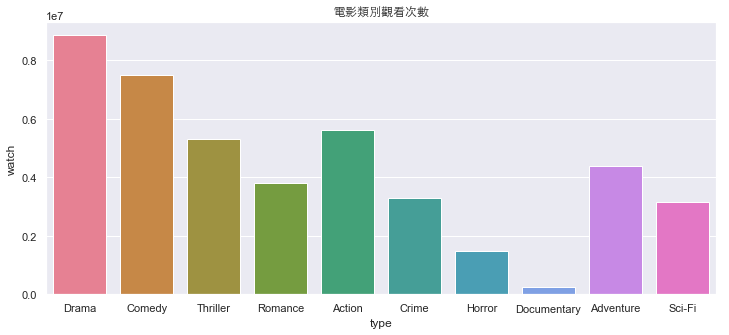

In [53]:
df_types_count = pd.DataFrame(types_count, columns=['type', 'watch'])
df_temp = pd.DataFrame(df_types_count.groupby('type')['watch'].sum().reset_index())
df_types = pd.merge(df_types, df_temp, on=['type'])
sns.barplot(x='type', y='watch', data=df_types, palette='husl')
plt.gcf().set_size_inches(12,5)
plt.title('電影類別觀看次數', fontproperties=font,size=12)
plt.show()

### 題材拍攝的趨勢

In [82]:
types_year = []
for i,j in list(zip(df_movie['genres'],df_movie['year'])):
    try:
        if int(j) >= 1995:
            for k in i.split('|'):
                types_year.append([k,j])
    except:
        pass

In [167]:
# 去除數量較少的類別
df_types_year = pd.DataFrame(types_year, columns=['type', 'year'])
df_types_year_count = pd.DataFrame(df_types_year.groupby(['type', 'year']).size().reset_index())
df_temp = df_types_year_count.groupby('type').sum()[0]
df_temp[df_temp < 500]

type
(no genres listed)    107
Film-Noir              35
IMAX                  187
Musical               374
War                   472
Western               111
Name: 0, dtype: int64

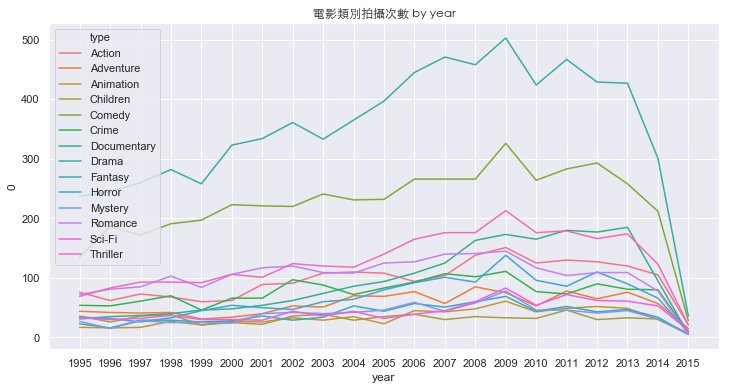

In [169]:
for i in df_temp[df_temp < 500].keys():
    df_types_year_count = df_types_year_count[df_types_year_count['type'] != i]
sns.lineplot(x="year", y=0, hue="type", data=df_types_year_count)
plt.gcf().set_size_inches(12,6)
plt.title('電影類別拍攝次數 by year', fontproperties=font,size=12)
plt.show()

### 看看類別組合的評分

In [182]:
import itertools
types_bigram_score = []
for i,j in list(zip(df_movie['genres'],df_movie['rating'])):
    for k in list(itertools.combinations(i.split('|'),2)):
        types_bigram_score.append([k,j])

### 受歡迎

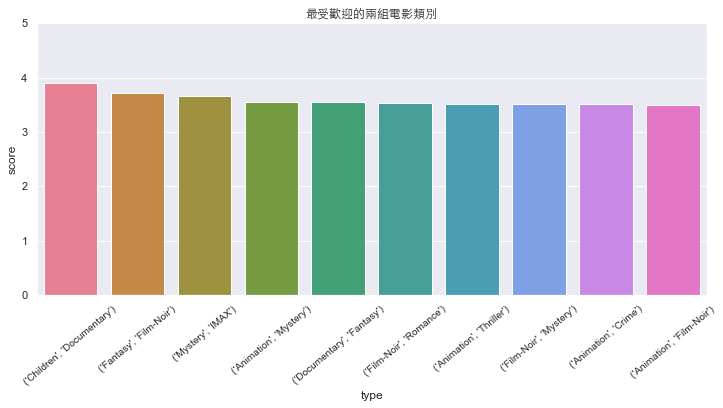

In [313]:
df_types_bigram_score = pd.DataFrame(types_bigram_score, columns=['type', 'score'])
df_temp = pd.DataFrame(df_types_bigram_score.groupby('type')['score'].mean().reset_index())
sns.barplot(x='type', y='score', data=df_temp, order=df_temp.sort_values('score', ascending=False)[0:10]['type'], palette='husl')
plt.title('最受歡迎的兩組電影類別', fontproperties=font, size=12)
plt.gcf().set_size_inches(12,5)
plt.xticks(rotation=40,size=10)
plt.ylim(0,5)
plt.show()

In [317]:
# 拍攝這題材的電影很受人們喜歡
df_movie[(df_movie['genres'].str.contains("Children")) & (df_movie['genres'].str.contains("Documentary"))]

,movieId,title,genres,rating,year
10131,33639,Mad Hot Ballroom (2005),Children|Documentary,3.875000,2005
22818,109571,Into the Middle of Nowhere (2010),Adventure|Children|Comedy|Documentary|Drama,5.000000,2010
24502,116953,Magic Camp (2012),Children|Documentary,3.666667,2012
26062,127268,Project Wild Thing (2013),Adventure|Children|Documentary|Drama,3.500000,2013
26556,130344,Coast of Death (2013),Children|Documentary|Drama,3.500000,2013


In [321]:
# 大於4分的黑色電影很多，反而應該注意低分群
df_movie[(df_movie['genres'].str.contains("Film-Noir")) & (df_movie['rating'] < 2)]

,movieId,title,genres,rating,year
2546,2631,Frogs for Snakes (1998),Comedy|Film-Noir|Thriller,1.680556,1998
16636,84250,Christmas Holiday (1944),Drama|Film-Noir,1.900000,1944


### 不受歡迎

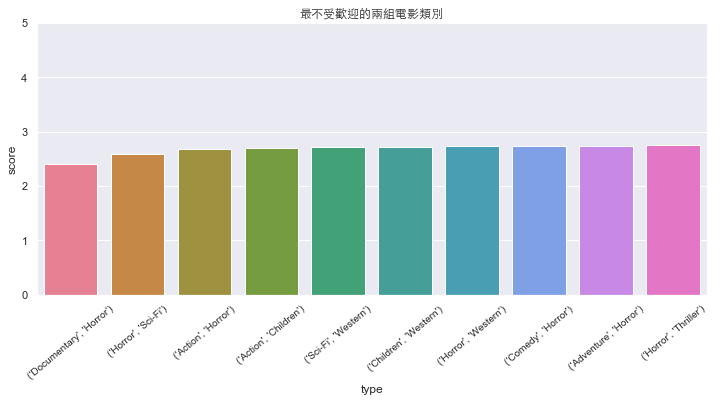

In [314]:
sns.barplot(x='type', y='score', data=df_temp, order=df_temp.sort_values('score', ascending=True)[0:10]['type'], palette='husl')
plt.title('最不受歡迎的兩組電影類別', fontproperties=font, size=12)
plt.gcf().set_size_inches(12,5)
plt.xticks(rotation=40,size=10)
plt.ylim(0,5)
plt.show()

In [67]:
# 很多低分群都是恐怖電影，應該參考得到高分的都怎麼拍攝
df_movie[(df_movie['genres'].str.contains("Horror")) & (df_movie['rating'] > 4)]

,movieId,title,genres,year,rating
587,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,1991,4.177057
1175,1200,Aliens (1986),Action|Adventure|Horror|Sci-Fi,1986,4.005642
1188,1214,Alien (1979),Horror|Sci-Fi,1979,4.041784
1193,1219,Psycho (1960),Crime|Horror,1960,4.076900
1230,1258,"Shining, The (1980)",Horror,1980,4.011534
2676,2762,"Sixth Sense, The (1999)",Drama|Horror|Mystery,1999,4.054999
7004,7116,Diabolique (Les diaboliques) (1955),Horror|Mystery|Thriller,1955,4.010932
12922,61240,Let the Right One In (Låt den rätte komma in) ...,Drama|Fantasy|Horror|Romance,2008,4.010526
16949,86023,Female Vampire (Les avaleuses) (Erotic Kill) (...,Horror,1973,4.500000
18827,93916,Genesis (1998),Drama|Horror,1998,4.125000


### 若是三組類別

In [217]:
types_trigram_score = []
for i,j in list(zip(df_movie['genres'],df_movie['rating'])):
    for k in list(itertools.combinations(i.split('|'),3)):
        types_trigram_score.append([k,j])

### 受歡迎

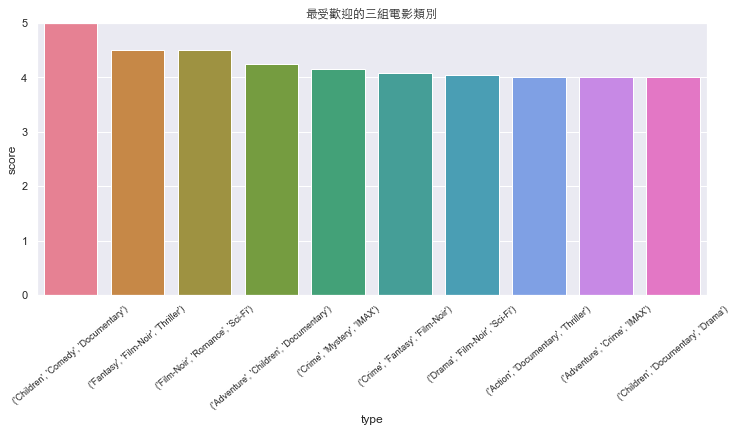

In [322]:
df_types_trigram_score = pd.DataFrame(types_trigram_score, columns=['type', 'score'])
df_temp = pd.DataFrame(df_types_trigram_score.groupby('type')['score'].mean().reset_index())
sns.barplot(x='type', y='score', data=df_temp, order=df_temp.sort_values('score', ascending=False)[0:10]['type'], palette='husl')
plt.title('最受歡迎的三組電影類別', fontproperties=font, size=12)
plt.gcf().set_size_inches(12,5)
plt.xticks(rotation=40,size=9)
plt.ylim(0,5)
plt.show()

In [323]:
# 只出現過一次所以5滿分
df_types_trigram_score[df_types_trigram_score['type']==df_types_trigram_score['type'][17140]]

,type,score
17140,"(Children, Comedy, Documentary)",5.0


### 不受歡迎

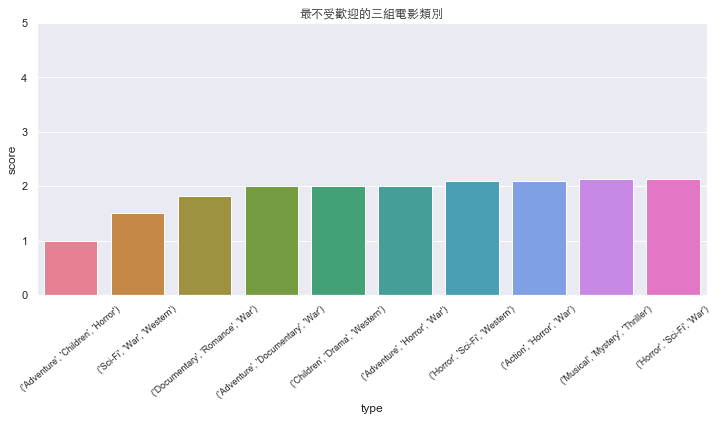

In [324]:
sns.barplot(x='type', y='score', data=df_temp, order=df_temp.sort_values('score', ascending=True)[0:10]['type'], palette='husl')
plt.title('最不受歡迎的三組電影類別', fontproperties=font, size=12)
plt.gcf().set_size_inches(12,5)
plt.xticks(rotation=40,size=9)
plt.ylim(0,5)
plt.show()

In [71]:
# 有戰爭片題材的出現很多次，同樣可以參考高分的
df_movie[(df_movie['genres'].str.contains("War")) & (df_movie['rating'] > 4)]

,movieId,title,genres,year,rating
108,110,Braveheart (1995),Action|Drama|War,1995,4.042534
212,214,Before the Rain (Pred dozhdot) (1994),Drama|War,1994,4.047240
352,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1994,4.029000
523,527,Schindler's List (1993),Drama|War,1993,4.310175
737,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,1964,4.247287
952,969,"African Queen, The (1951)",Adventure|Comedy|Romance|War,1951,4.101558
1155,1178,Paths of Glory (1957),Drama|War,1957,4.232623
1179,1204,Lawrence of Arabia (1962),Adventure|Drama|War,1962,4.162102
1182,1208,Apocalypse Now (1979),Action|Drama|War,1979,4.108900
1191,1217,Ran (1985),Drama|War,1985,4.173611
